In [1]:
%load_ext line_profiler

In [2]:
# Import Qiskit Library
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli, Statevector
from qiskit.circuit.library import UnitaryGate  

from pauli_propagation import PauliTerm, PauliPropagator
from pauli_propagation.utils import random_su4

import matplotlib.pyplot as plt
import logging
import numpy as np
import random

logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

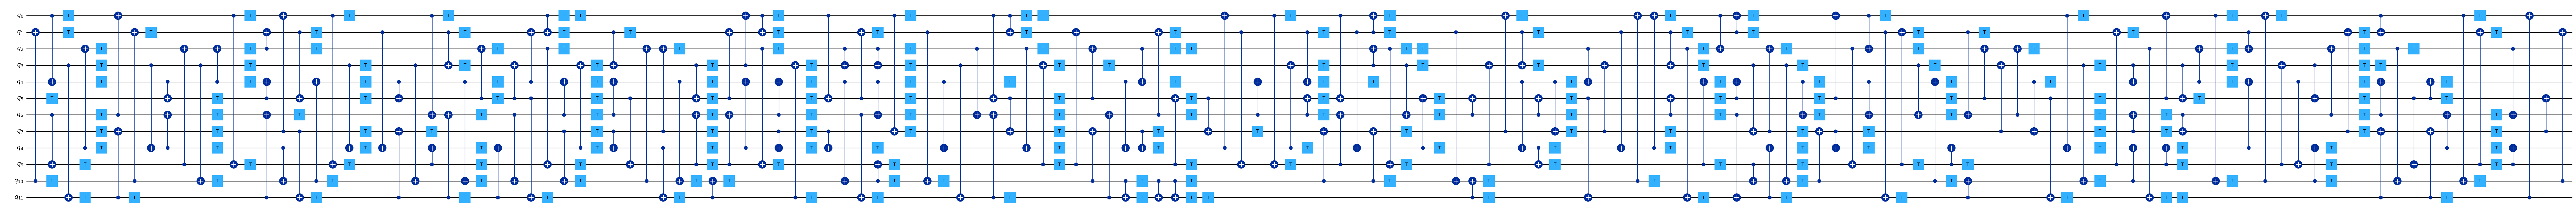

In [3]:
num_qubits = 12
qc = QuantumCircuit(num_qubits, name="random_speed_test")
# Set a random seed for reproducibility
random.seed(42)
for _ in range(20):
    qs = random.sample(range(num_qubits), 10)
    qc.cx(qs[0], qs[1])
    qc.cx(qs[2], qs[3])
    qc.cx(qs[4], qs[5])
    qc.cx(qs[6], qs[7])
    qc.cx(qs[8], qs[9])

    # ———— 给每个 qubit 都加 T ————
    for q in range(num_qubits):
        qc.t(q)

    # ———— 第二轮随机 CNOT ————
    qs2 = random.sample(range(num_qubits), 10)
    qc.cx(qs2[0], qs2[1])
    qc.cx(qs2[2], qs2[3])
    qc.cx(qs2[4], qs2[5])
    qc.cx(qs2[6], qs2[7])
    qc.cx(qs2[8], qs2[9])

# for _ in range(20):
#     qs = random.sample(range(num_qubits),10)
#     for i in range(0,10,2):
#         qc.cx(qs[i], qs[i+1])
#     for q in range(num_qubits):
#         qc.t(q)

# # # --- draw exactly ONE figure ---
fig = qc.draw(output="mpl",fold=-1)   # create the figure object
plt.show()                    # display it once

In [4]:

# 12 qubit是29s
# 15 qubit: 4min11s
prop   = PauliPropagator(qc)
pauli_label = "X" + "I" * (num_qubits - 1)

layers = prop.propagate(PauliTerm(1.0, Pauli(pauli_label)), max_weight=None)   
expect = prop.expectation_pauli_sum(pauli_sum= layers[-1],
                                    product_label= "+"*num_qubits)   # |+⟩^{⊗3}                  
         
print(expect)

# print("layer | Pauli decomposition")
# for k, plist in enumerate(layers[::-1]):      
#     line = "  ".join(map(str, plist))
#     print(f"{k:>5} : {line}")

-0.015624999999999872


In [5]:
# --- prepare |+>⊗3 as statevector ---
psi0 = Statevector.from_label("+"*num_qubits)

# --- evolve through the circuit ---
psi_final = psi0.evolve(qc)
# --- build X on qubit‑1 ("IXI") and compute expectation ---
obs = Pauli(pauli_label)
exp_val = psi_final.expectation_value(obs).real

print(f"⟨X1⟩ from statevector simulation: {exp_val:.6f}")

⟨X1⟩ from statevector simulation: -0.015625


# Above is first demo

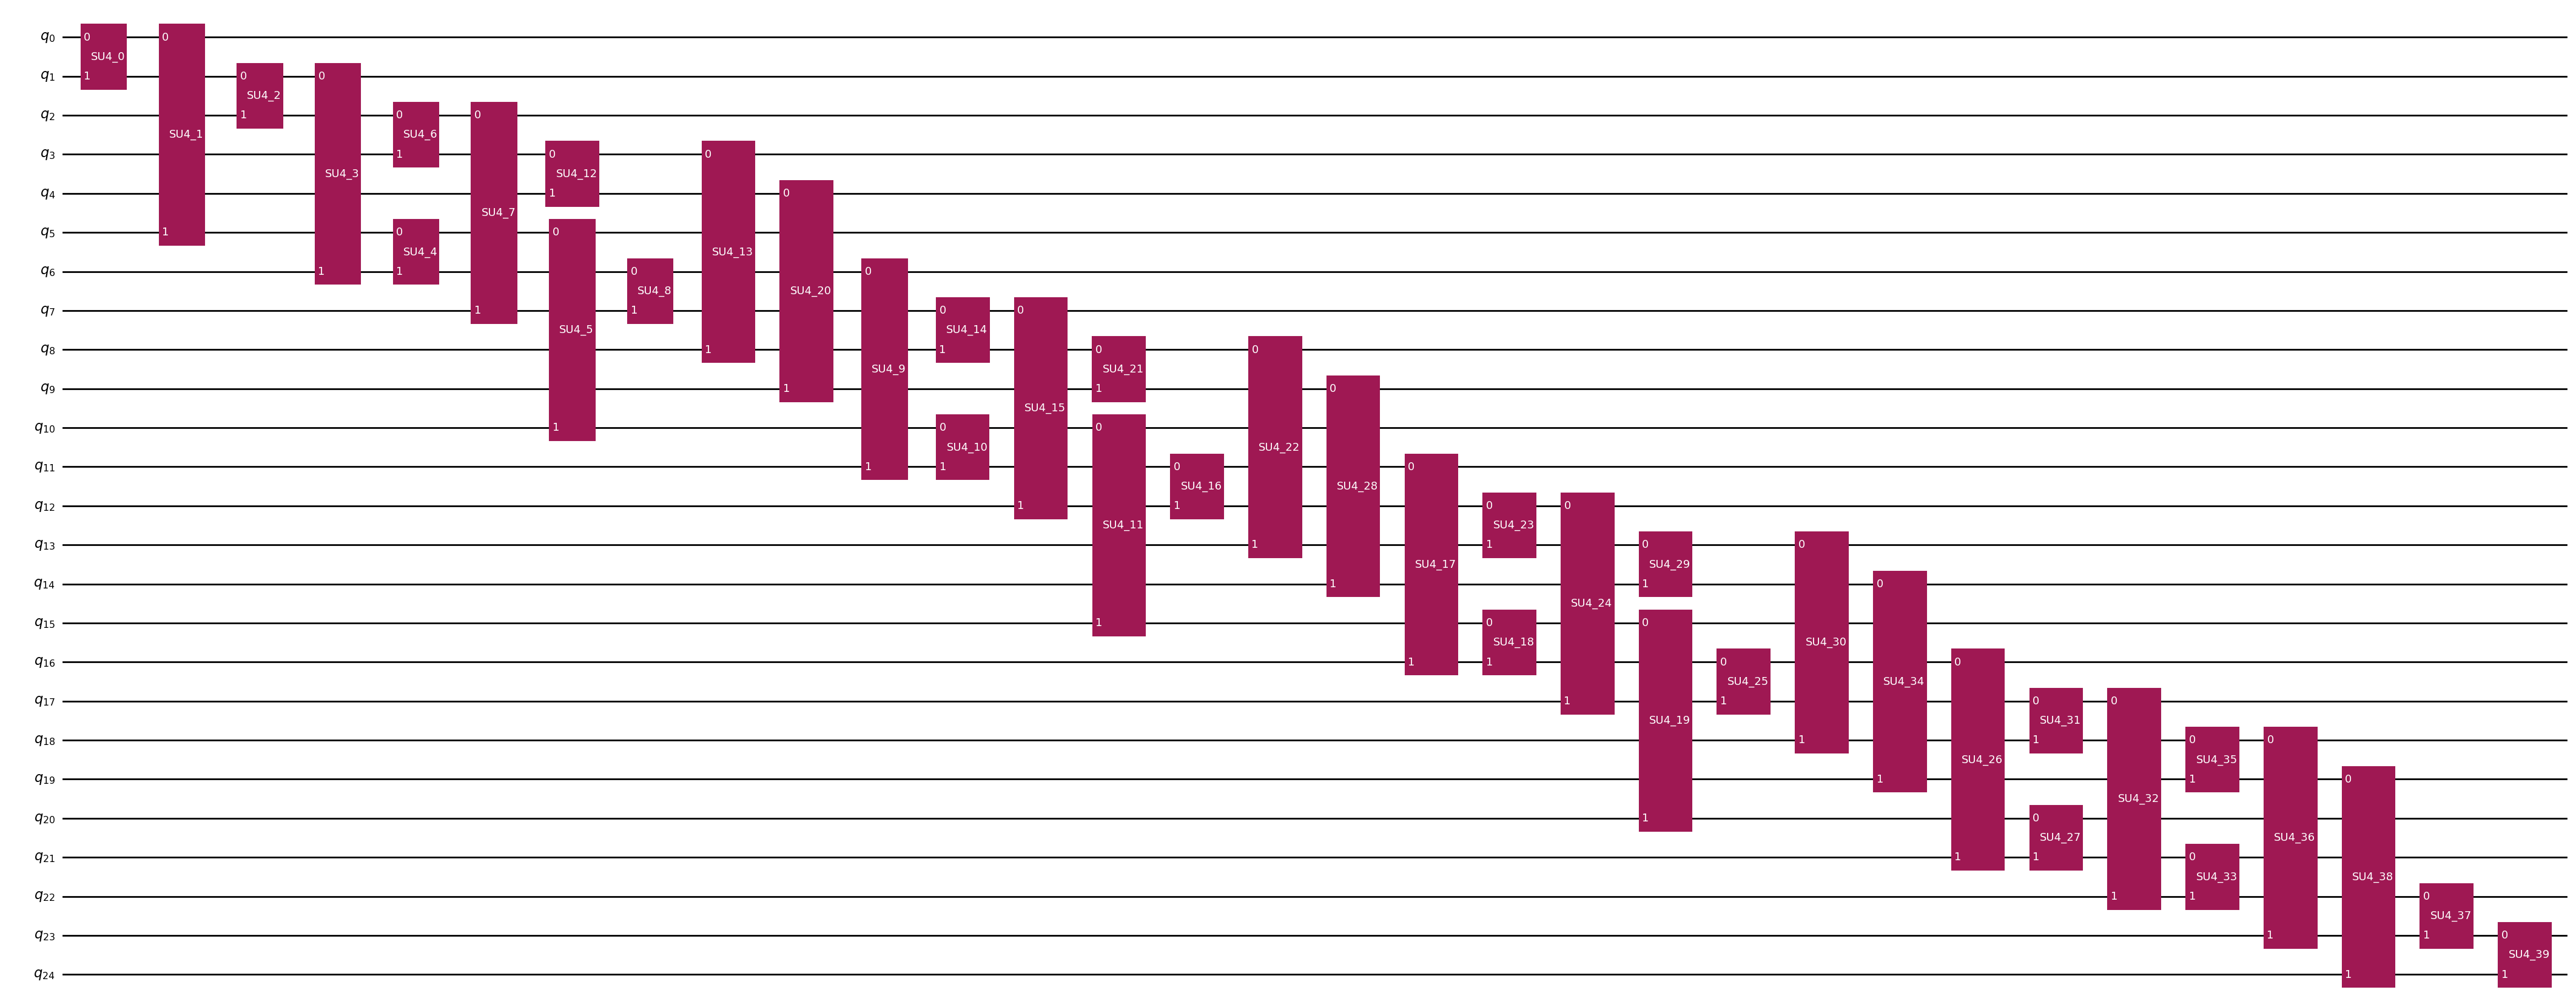

In [6]:
# 设置随机种子以确保结果可重复
np.random.seed(42)  # 使用42作为随机种子

def _staircase_edges(nx, ny):
    """Return the ordered list of 1-based index pairs of the staircase walk."""
    next_inds, temp_inds, edges = [1], [], []
    while next_inds:
        for ind in next_inds:
            if ind % nx != 0:                      # step right
                nxt = ind + 1
                edges.append((ind, nxt)); temp_inds.append(nxt)
            if ((ind-1)//nx + 1) < ny:             # step down
                nxt = ind + nx
                edges.append((ind, nxt)); temp_inds.append(nxt)
        next_inds, temp_inds = temp_inds, []
    seen, uniq = set(), []
    for e in edges:                                # preserve order, dedup
        if e not in seen:
            seen.add(e); uniq.append(e)
    return uniq

def staircasetopology2d_qc(nx, ny):
    """
    Build a QuantumCircuit that places a fresh SU(4) gate on every edge
    of the 2-D staircase topology for an nx × ny grid (row-major indexing).
    """
    nqubits = nx * ny
    qc = QuantumCircuit(nqubits)
    for k, (q1, q2) in enumerate(_staircase_edges(nx, ny)):  # 1-based
        mat = random_su4()
        gate = UnitaryGate(mat, label=f"SU4_{k}")   # create the gate
        gate._name = "su4"                          # override its name
        qc.append(gate, [q1-1, q2-1])               # 0-based
    return qc

# Example usage:
nx, ny = 5,5
qc_2d = staircasetopology2d_qc(nx, ny)

fig = qc_2d.draw(output="mpl", fold=-1)   # no line-wrapping
plt.show()

In [7]:
n = qc_2d.num_qubits # Here n is number of qubit in 2d circuit

plus_label = "+" * n # build a string of "+" of length n, e.g. "+++++"

# ─── Build the single-qubit X observable on qubit 0 ───────────────────────────
pauli_label = "X" + "I" * (n - 1) # For X on qubit 0 and Identity elsewhere, we need "X" + "I"*(n-1)
obs = Pauli(pauli_label)

# ─── Evolve the statevector through the 2D staircase circuit ─────────────────
psi0 = Statevector.from_label(plus_label)
psi_final = psi0.evolve(qc_2d)

# ─── Compute and print the expectation value ───────────────────────────────────
exp_val = psi_final.expectation_value(obs).real
print(f"⟨X on qubit 0⟩ from statevector simulation: {exp_val:.6f}")

⟨X on qubit 0⟩ from statevector simulation: 0.157547


In [8]:
# 25 qubit, 1 layer, weight 3, 1min1s
# 36 qubit, 1 layer, weight 3, takes 3min46s, 

In [9]:
prop_2d   = PauliPropagator(qc_2d)
print('1')

layers_2d = prop_2d.propagate(PauliTerm(1.0, Pauli(pauli_label)), max_weight = 3)   
print('2')
expect_2d = prop_2d.expectation_pauli_sum(pauli_sum= layers_2d[-1],
                                    product_label= plus_label)   # |+⟩^{⊗n}                  
print('3')
print(expect_2d)

1
2
3
0.12079133418758356


In [10]:
# %lprun -f PauliPropagator.propagate \
# prop_2d.propagate(PauliTerm(1.0, Pauli(pauli_label)), max_weight=3)

In [11]:



# prop_2d   = PauliPropagator(qc_2d)
# print('1')

# %lprun -f PauliPropagator.propagate \
# layers_2d = prop_2d.propagate(PauliTerm(1.0, Pauli(pauli_label)), max_weight = 3)   
# print('2')
# expect_2d = prop_2d.expectation_pauli_sum(pauli_sum= layers_2d[-1],
#                                     product_label= plus_label)   # |+⟩^{⊗n}                  
# print('3')
# print(expect_2d)

In [12]:
# after passing all test, play with truncation
# implement more gates (should be fully compatble with qiskit)
# compare simulation with tensor network, quimb
# play with circuit people considered(portfolio optimisaiton)

In [13]:
# 写test suite
# 和state vector方法对比性能
# implement更多门
# QuantumGate.get(instr.operation.name)

# 知道电路在很多observable下的expectation不就行了嘛？为什么还要费劲巴拉地做simulation?

# 还是不太理解_cx_rule和_t_rule的具体实现，给我例子说明具体实现

# 没见过这种语法：bucket: defaultdict[str, complex] = defaultdict(complex)


# 还是不理解merge_like_terms的具体实现，给例子

# _cx_rule 以及 PauliPropagation” 的设计思路有帮助。它们一起完成“在泡利基中对可观测量做非 Clifford 演化并在重量上进行截断”的功能。


#     @classmethod
#     def register(cls, name: str):
#         """Decorator: register a new rule under *name* and
#         attach it as <NAME>gate attribute for convenience."""
#         def wrapper(func: Callable):
#             cls._registry[name] = func
#             setattr(cls, f"{name.upper()}gate", staticmethod(func))
#             return staticmethod(func)
#         return wrapper
